**Identificación de Parámetros en Sistemas de Múltiples Grados de Libertad**

In [1]:
#Importación de módulos de cálculo y graficación
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
#Importación de la data
Data = np.loadtxt("Data.txt")
frec = Data[:,0]
AmplitudH11 = Data[:,1]
AmplitudH12 = Data[:,2]
AmplitudH21 = Data[:,3]
AmplitudH22 = Data[:,4]
FaseH11 = Data[:,5]
FaseH12 = Data[:,6]
FaseH21 = Data[:,7]
FaseH22 = Data[:,8]

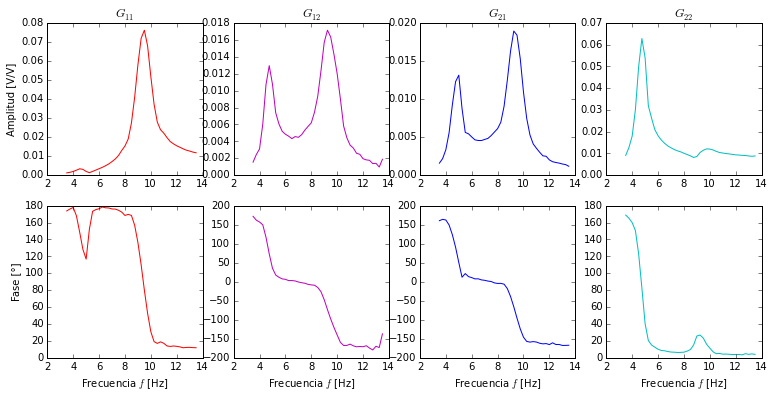

In [3]:
#Gráficas de mediciones
fig, ax = plt.subplots(2, 4, figsize=(12.8,6))

#G11
ax[0,0].plot(frec, AmplitudH11, 'r')
ax[0,0].set_title('$G_{11}$')
ax[0,0].set_ylabel('Amplitud [V/V]')
ax[1,0].plot(frec, FaseH11, 'r')
ax[1,0].set_ylabel('Fase [°]')
ax[1,0].set_xlabel('Frecuencia $f$ [Hz]')

#G12
ax[0,1].plot(frec, AmplitudH12, 'm')
ax[0,1].set_title('$G_{12}$')
ax[1,1].plot(frec, FaseH12, 'm')
ax[1,1].set_xlabel('Frecuencia $f$ [Hz]')

#G21
ax[0,2].plot(frec, AmplitudH21, 'b')
ax[0,2].set_title('$G_{21}$')
ax[1,2].plot(frec, FaseH21, 'b')
ax[1,2].set_xlabel('Frecuencia $f$ [Hz]')

#G22
ax[0,3].plot(frec, AmplitudH22, 'c')
ax[0,3].set_title('$G_{22}$')
ax[1,3].plot(frec, FaseH22, 'c')
ax[1,3].set_xlabel('Frecuencia $f$ [Hz]')

In [4]:
#Definición de ganancias de instrumentación
G_acel = 99.1                   #Ganancia del acelerómetro [mV/g]
G_mart = 2.25                   #Ganancia del martillo de impacto [V/N]
Gan = G_mart*(1000*9.8/G_acel)  #Ganancia total [(m/s^2)/N]

In [5]:
#Construcción de la matriz G [m/N]
L = len(frec)                       #Número de filas de los datos (hasta 200 Hz)                    #Longitud para la matriz de interés (hasta 20 Hz)
G = np.zeros((L, 4), dtype=complex) #Inicialización de la matriz G de dimensiones dx4
for n in range(0, L, 1):
    G[n, 0] = Gan*AmplitudH11[n]*np.cos(FaseH11[n]*np.pi/180) + 1j*Gan*AmplitudH11[n]*np.sin(FaseH11[n]*np.pi/180)
    G[n, 1] = Gan*AmplitudH12[n]*np.cos(FaseH12[n]*np.pi/180) + 1j*Gan*AmplitudH12[n]*np.sin(FaseH12[n]*np.pi/180)
    G[n, 2] = Gan*AmplitudH21[n]*np.cos(FaseH21[n]*np.pi/180) + 1j*Gan*AmplitudH21[n]*np.sin(FaseH21[n]*np.pi/180)
    G[n, 3] = Gan*AmplitudH22[n]*np.cos(FaseH22[n]*np.pi/180) + 1j*Gan*AmplitudH22[n]*np.sin(FaseH22[n]*np.pi/180)
    #Doble integración para llevar la aceleración a desplazamiento
    G[n, :] = (1/(-(2*np.pi*frec[n])**2))*G[n, :]

In [6]:
#Construcción de la matriz H=G^(-1)
H = np.zeros_like(G)
for n in range(0, L, 1):
    Gi = np.array([[G[n, 0], G[n, 1]],
                  [G[n, 2], G[n, 3]]])
    Hi = np.linalg.inv(Gi)
    H[n, 0] = Hi[0,0]
    H[n, 1] = Hi[0,1]
    H[n, 2] = Hi[1,0]
    H[n, 3] = Hi[1,1]

In [7]:
#Vector de frecuencia angular
omega = 2*np.pi*frec

omegaI = np.zeros(L+1)
for n in range(0, L, 1):
    omegaI[n+1] = omega[n]

In [8]:
#Definición de función para ajustes
def func_real(omega, k, m):
    """Modelo de parábola para ajuste de componente real"""
    return k - m*omega**2

def func_imag(omega, c):
    """Modelo de recta para ajuste de componente imaginaria"""
    return c*omega

k11 [N/m] =  2425.795239
m11 [kg] =  0.720264
c11 [N-s/m] =  3.744733


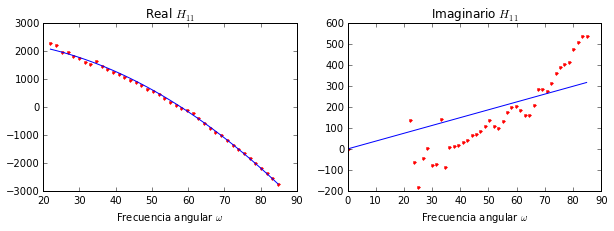

In [9]:
#Componente H11
H11 = H[:, 0]

#Ajuste por mínimos cuadrados
#Parte real
(a1, b1),_ = curve_fit(func_real, omega, H11.real)  

#Parte imaginaria
H11IM = np.zeros(L+1)
for n in range(0, L, 1):
    H11IM[n+1] = H11.imag[n]
(c1),_ = curve_fit(func_imag, omegaI, H11IM)    

#Componentes
print("k11 [N/m] = ", "%0.6f" % a1)
print("m11 [kg] = ", "%0.6f" % b1)
print("c11 [N-s/m] = ", "%0.6f" % c1)

#Funciones
#Parte real    
y_fit1 = func_real(omega, a1, b1)         
#Parte imaginaria
y_fit2 = func_imag(omegaI, c1)   

#Gráficas
fig, ax = plt.subplots(1, 2, figsize=(10,3))
#Parte real
ax[0].plot(omega, H11.real, '.r')
ax[0].plot(omega, y_fit1, 'b')
ax[0].set_title('Real $H_{11}$')
ax[0].set_xlabel('Frecuencia angular $\omega$')
#Parte imaginaria
ax[1].plot(omegaI, H11IM, '.r')
ax[1].plot(omegaI, y_fit2, 'b')
ax[1].set_title('Imaginario $H_{11}$')
ax[1].set_xlabel('Frecuencia angular $\omega$')

k12 [N/m] =  -362.763956
m12 [kg] =  0.002463
c12 [N-s/m] =  0.385932


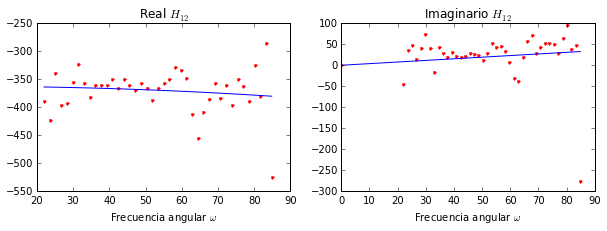

In [10]:
#Componente H12
H12 = H[:, 1]

#Ajuste por mínimos cuadrados
#Parte real
(a2, b2),_ = curve_fit(func_real, omega, H12.real)  

#Parte imaginaria
H12IM = np.zeros(L+1)
for n in range(0, L, 1):
    H12IM[n+1] = H12.imag[n]
(c2),_ = curve_fit(func_imag, omegaI, H12IM)    

#Componentes
print("k12 [N/m] = ", "%0.6f" % a2)
print("m12 [kg] = ", "%0.6f" % b2)
print("c12 [N-s/m] = ", "%0.6f" % c2)

#Funciones
#Parte real    
y_fit1 = func_real(omega, a2, b2)         
#Parte imaginaria
y_fit2 = func_imag(omegaI, c2)   

#Gráficas
fig, ax = plt.subplots(1, 2, figsize=(10,3))
#Parte real
ax[0].plot(omega, H12.real, '.r')
ax[0].plot(omega, y_fit1, 'b')
ax[0].set_title('Real $H_{12}$')
ax[0].set_xlabel('Frecuencia angular $\omega$')
#Parte imaginaria
ax[1].plot(omegaI, H12IM, '.r')
ax[1].plot(omegaI, y_fit2, 'b')
ax[1].set_title('Imaginario $H_{12}$')
ax[1].set_xlabel('Frecuencia angular $\omega$')

k21 [N/m] =  -366.161338
m21 [kg] =  0.001691
c21 [N-s/m] =  0.017896


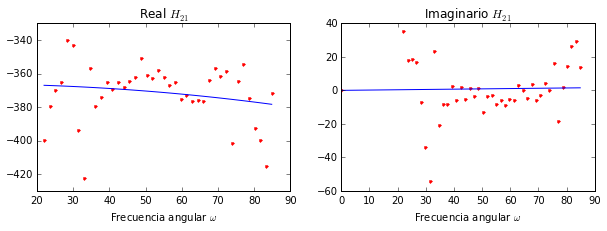

In [11]:
#Componente H21
H21 = H[:, 2]

#Ajuste por mínimos cuadrados
#Parte real
(a3, b3),_ = curve_fit(func_real, omega, H21.real)  

#Parte imaginaria
H21IM = np.zeros(L+1)
for n in range(0, L, 1):
    H21IM[n+1] = H21.imag[n]
(c3),_ = curve_fit(func_imag, omegaI, H21IM)    

#Componentes
print("k21 [N/m] = ", "%0.6f" % a3)
print("m21 [kg] = ", "%0.6f" % b3)
print("c21 [N-s/m] = ", "%0.6f" % c3)

#Funciones
#Parte real    
y_fit1 = func_real(omega, a3, b3)         
#Parte imaginaria
y_fit2 = func_imag(omegaI, c3)   

#Gráficas
fig, ax = plt.subplots(1, 2, figsize=(10,3))
#Parte real
ax[0].plot(omega, H21.real, '.r')
ax[0].plot(omega, y_fit1, 'b')
ax[0].set_title('Real $H_{21}$')
ax[0].set_xlabel('Frecuencia angular $\omega$')
#Parte imaginaria
ax[1].plot(omegaI, H21IM, '.r')
ax[1].plot(omegaI, y_fit2, 'b')
ax[1].set_title('Imaginario $H_{21}$')
ax[1].set_xlabel('Frecuencia angular $\omega$')

k22 [N/m] =  607.209596
m22 [kg] =  0.599723
c22 [N-s/m] =  2.126782


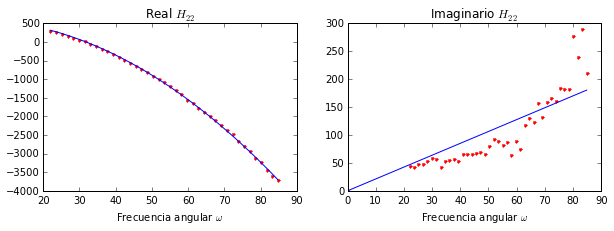

In [12]:
#Componente H22
H22 = H[:, 3]

#Ajuste por mínimos cuadrados
#Parte real
(a4, b4),_ = curve_fit(func_real, omega, H22.real)  

#Parte imaginaria
H22IM = np.zeros(L+1)
for n in range(0, L, 1):
    H22IM[n+1] = H22.imag[n]
(c4),_ = curve_fit(func_imag, omegaI, H22IM)    

#Componentes
print("k22 [N/m] = ", "%0.6f" % a4)
print("m22 [kg] = ", "%0.6f" % b4)
print("c22 [N-s/m] = ", "%0.6f" % c4)

#Funciones
#Parte real    
y_fit1 = func_real(omega, a4, b4)         
#Parte imaginaria
y_fit2 = func_imag(omegaI, c4)   

#Gráficas
fig, ax = plt.subplots(1, 2, figsize=(10,3))
#Parte real
ax[0].plot(omega, H22.real, '.r')
ax[0].plot(omega, y_fit1, 'b')
ax[0].set_title('Real $H_{22}$')
ax[0].set_xlabel('Frecuencia angular $\omega$')
#Parte imaginaria
ax[1].plot(omegaI, H22IM, '.r')
ax[1].plot(omegaI, y_fit2, 'b')
ax[1].set_title('Imaginario $H_{22}$')
ax[1].set_xlabel('Frecuencia angular $\omega$')

In [13]:
#Matriz de masa [kg]
M = np.array([[b1, b2],
              [b3, b4]])
print("Matriz de masa [kg]")
print(M)

Matriz de masa [kg]
[[ 0.7202636   0.00246341]
 [ 0.00169137  0.59972293]]


In [14]:
#Matriz de rigidez [N/m]
K = np.array([[a1, a2],
              [a3, a4]])
print("Matriz de rigidez [N/m]")
print(K)

Matriz de rigidez [N/m]
[[ 2425.79523937  -362.76395649]
 [ -366.16133811   607.20959596]]


In [15]:
#Matriz de amortiguación [N-s/m]
C = np.array([[c1[0], c2[0]],
              [c3[0], c4[0]]])
print("Matriz de amortiguación [N-s/m]")
print(C)

Matriz de amortiguación [N-s/m]
[[ 3.74473254  0.38593243]
 [ 0.01789558  2.12678201]]


In [16]:
#Verificación de resultados

def Hij(x, b, a, c):
    return -(x**2)*b + 1j*x*c + a

In [17]:
H11teo = np.zeros(L, dtype=complex)
H12teo = np.zeros(L, dtype=complex)
H21teo = np.zeros(L, dtype=complex)
H22teo = np.zeros(L, dtype=complex)
Gteo = np.zeros((L, 4), dtype=complex)

for n in range(0, L, 1):
    H11teo[n] = Hij(omega[n], b1, a1, c1[0])
    H12teo[n] = Hij(omega[n], b2, a2, c2[0])
    H21teo[n] = Hij(omega[n], b3, a3, c3[0])
    H22teo[n] = Hij(omega[n], b4, a4, c4[0])
    MatrixHij = np.array([[H11teo[n], H12teo[n]],
                         [H21teo[n], H22teo[n]]])
    Gij = np.linalg.inv(MatrixHij)
    Gteo[n, 0] = Gij[0,0]
    Gteo[n, 1] = Gij[0,1]
    Gteo[n, 2] = Gij[1,0]
    Gteo[n, 3] = Gij[1,1]

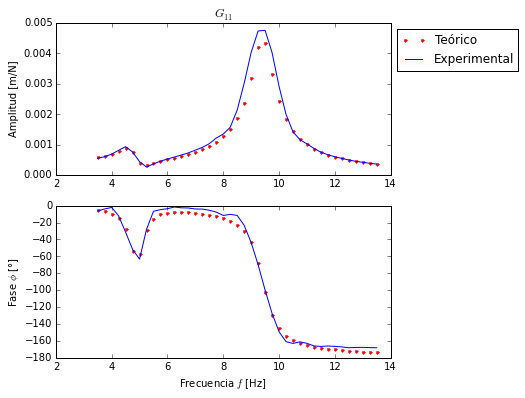

In [18]:
#Componente G11
#Determinación de la fase en grados
faseG11 = np.arctan2(Gteo[:,0].imag, Gteo[:,0].real) * 180 / np.pi
fasG11_med = np.arctan2(G[:,0].imag, G[:,0].real) * 180 / np.pi

#Gráficas
fig, ax = plt.subplots(2, 1, figsize=(6,6))
#Amplitud
ax[0].plot(frec, np.abs(Gteo[:,0]), '.r', label='Teórico') 
ax[0].plot(frec, np.abs(G[:,0]), 'b', label='Experimental')
ax[0].set_title('$G_{11}$')
ax[0].set_ylabel('Amplitud [m/N]')
ax[0].legend(bbox_to_anchor=(1,1), loc=2)
#Fase
ax[1].plot(frec, faseG11, '.r')
ax[1].plot(frec, fasG11_med, 'b')
ax[1].set_xlabel('Frecuencia $f$ [Hz]')
ax[1].set_ylabel('Fase $\phi$ [°]')

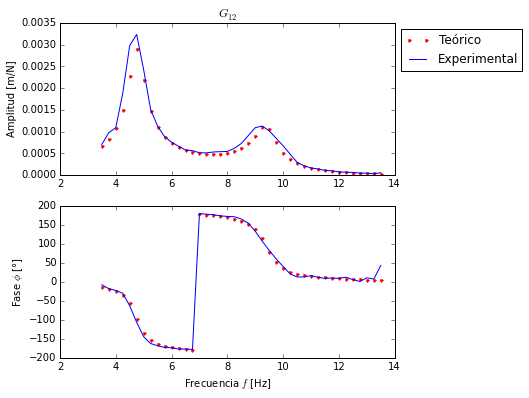

In [19]:
#Componente G12
#Determinación de la fase en grados
faseG12 = np.arctan2(Gteo[:,1].imag, Gteo[:,1].real) * 180 / np.pi
fasG12_med = np.arctan2(G[:,1].imag, G[:,1].real) * 180 / np.pi

#Gráficas
fig, ax = plt.subplots(2, 1, figsize=(6,6))
#Amplitud
ax[0].plot(frec, np.abs(Gteo[:,1]), '.r', label='Teórico') 
ax[0].plot(frec, np.abs(G[:,1]), 'b', label='Experimental')
ax[0].set_title('$G_{12}$')
ax[0].set_ylabel('Amplitud [m/N]')
ax[0].legend(bbox_to_anchor=(1,1), loc=2)
#Fase
ax[1].plot(frec, faseG12, '.r')
ax[1].plot(frec, fasG12_med, 'b')
ax[1].set_xlabel('Frecuencia $f$ [Hz]')
ax[1].set_ylabel('Fase $\phi$ [°]')

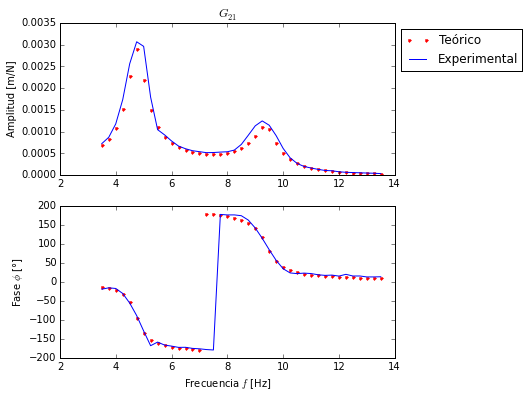

In [20]:
#Componente G21
#Determinación de la fase en grados
faseG21 = np.arctan2(Gteo[:,2].imag, Gteo[:,2].real) * 180 / np.pi
fasG21_med = np.arctan2(G[:,2].imag, G[:,2].real) * 180 / np.pi

#Gráficas
fig, ax = plt.subplots(2, 1, figsize=(6,6))
#Amplitud
ax[0].plot(frec, np.abs(Gteo[:,2]), '.r', label='Teórico') 
ax[0].plot(frec, np.abs(G[:,2]), 'b', label='Experimental')
ax[0].set_title('$G_{21}$')
ax[0].set_ylabel('Amplitud [m/N]')
ax[0].legend(bbox_to_anchor=(1,1), loc=2)
#Fase
ax[1].plot(frec, faseG21, '.r')
ax[1].plot(frec, fasG21_med, 'b')
ax[1].set_xlabel('Frecuencia $f$ [Hz]')
ax[1].set_ylabel('Fase $\phi$ [°]')

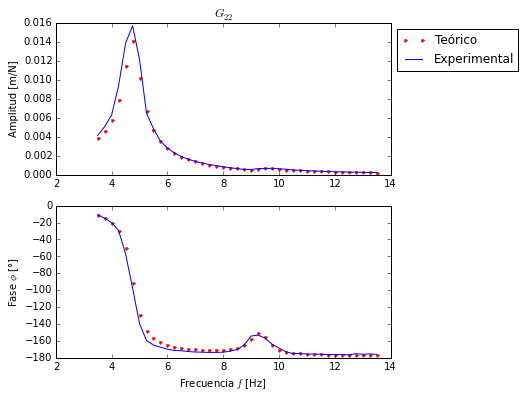

In [21]:
#Componente G22
#Determinación de la fase en grados
faseG22 = np.arctan2(Gteo[:,3].imag, Gteo[:,3].real) * 180 / np.pi
fasG22_med = np.arctan2(G[:,3].imag, G[:,3].real) * 180 / np.pi

#Gráficas
fig, ax = plt.subplots(2, 1, figsize=(6,6))
#Amplitud
ax[0].plot(frec, np.abs(Gteo[:,3]), '.r', label='Teórico') 
ax[0].plot(frec, np.abs(G[:,3]), 'b', label='Experimental')
ax[0].set_title('$G_{22}$')
ax[0].set_ylabel('Amplitud [m/N]')
ax[0].legend(bbox_to_anchor=(1,1), loc=2)
#Fase
ax[1].plot(frec, faseG22, '.r')
ax[1].plot(frec, fasG22_med, 'b')
ax[1].set_xlabel('Frecuencia $f$ [Hz]')
ax[1].set_ylabel('Fase $\phi$ [°]')